# Cat vs Dog Image Classifier Notebook

This notebook implements a binary image classifier to distinguish between cats and dogs using TensorFlow and Keras. The model uses a simple but effective CNN architecture optimized for this specific dataset.

## Dataset

The model is trained on the Kaggle \"Dog vs Cat\" dataset containing 1000 images (500 cats, 500 dogs) which is automatically downloaded when running the notebook.

## 1. Import Libraries and Setup

This cell imports all necessary libraries and sets up the environment for reproducible results.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers
import matplotlib.pyplot as plt
from pathlib import Path
import random
import kagglehub
import warnings

# Suppress warnings and reduce TensorFlow logging for cleaner output
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for reproducible results across runs
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

print("Libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")

## 2. Download and Examine Dataset

This cell automatically downloads the dataset from Kaggle and examines its structure. The dataset contains 500 cat images and 500 dog images in PNG format.

In [ ]:
# Download the Kaggle dataset automatically
print("Downloading Kaggle dataset...")
data_path = kagglehub.dataset_download("anthonytherrien/dog-vs-cat")
data_dir = Path(data_path) / "animals"
print(f"Dataset downloaded to: {data_dir}")

# Examine the dataset structure and count images
print(f"\nDataset structure:")
for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        count = len(list(class_dir.glob('*.png')))
        print(f"   - {class_dir.name}: {count} images")

## 3. Data Preprocessing Functions

This cell defines functions to load, preprocess, and augment images. The preprocessing is kept minimal to maintain high accuracy.

In [ ]:
def load_and_preprocess_image(path, label, img_size=(256, 256)):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1] range
    return image, label

def augment_image(image, label):
    # Only apply basic augmentation that doesn't distort the image too much
    image = tf.image.random_flip_left_right(image)  # Horizontal flip
    image = tf.image.random_brightness(image, 0.05)  # Slight brightness adjustment
    return image, label

print("Data preprocessing functions defined successfully")

## 4. Create Dataset

This cell creates TensorFlow datasets for training and validation. It splits the data 80/20, shuffles it, and applies preprocessing.

In [ ]:
def create_dataset(data_dir, img_size=(256, 256), batch_size=32, validation_split=0.2):
    # Collect all image paths and their corresponding labels
    image_paths = []
    labels = []
    
    for class_dir in data_dir.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name.lower()
            if 'cat' in class_name:
                label = 0  # Cat = 0
            elif 'dog' in class_name:
                label = 1  # Dog = 1
            else:
                continue
                
            # Add all PNG images from this class directory
            for img_path in class_dir.glob('*.png'):
                image_paths.append(str(img_path))
                labels.append(label)
    
    print(f"Found {len(image_paths)} images total")
    print(f"   - {sum(1 for l in labels if l == 0)} cat images")  
    print(f"   - {sum(1 for l in labels if l == 1)} dog images")
    
    # Shuffle data and split into training and validation sets
    combined = list(zip(image_paths, labels))
    random.shuffle(combined)
    image_paths, labels = zip(*combined)
    
    split_idx = int(len(image_paths) * (1 - validation_split))
    train_paths = list(image_paths[:split_idx])
    train_labels = list(labels[:split_idx])
    val_paths = list(image_paths[split_idx:])
    val_labels = list(labels[split_idx:])
    
    print(f"   - Training: {len(train_paths)} images")
    print(f"   - Validation: {len(val_paths)} images")
    
    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    
    # Apply preprocessing pipeline
    train_dataset = (train_dataset
                    .map(lambda p, l: load_and_preprocess_image(p, l, img_size))
                    .map(augment_image)  # Apply augmentation to training data only
                    .batch(batch_size)
                    .prefetch(tf.data.AUTOTUNE))
    
    val_dataset = (val_dataset
                  .map(lambda p, l: load_and_preprocess_image(p, l, img_size))
                  .batch(batch_size)
                  .prefetch(tf.data.AUTOTUNE))
    
    return train_dataset, val_dataset

# Configuration parameters
IMG_SIZE = (256, 256)  # Image dimensions
BATCH_SIZE = 32        # Batch size for training

# Create the datasets
train_ds, val_ds = create_dataset(data_dir, IMG_SIZE, BATCH_SIZE)
print("\nDatasets created successfully")

## 5. Visualize Sample Images

This cell displays a sample of training images to verify the data loading and preprocessing is working correctly.

In [ ]:
# Display sample images from the training dataset
class_names = ['Cat', 'Dog']

plt.figure(figsize=(12, 8))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        plt.title(f'{class_names[labels[i]]}')
        plt.axis('off')
plt.suptitle('Sample Training Images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Model Architecture

This cell defines and builds the CNN model. The architecture uses 4 convolutional blocks followed by dense layers for classification.

In [ ]:
def build_simple_cnn_model(input_shape=(256, 256, 3)):
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),
        
        # First convolutional block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),
        tf.keras.layers.MaxPooling2D(2, 2, padding='valid'),
        
        # Second convolutional block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
        tf.keras.layers.MaxPooling2D(2, 2, padding='valid'),
        
        # Third convolutional block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='valid'),
        tf.keras.layers.MaxPooling2D(2, 2, padding='valid'),
        
        # Fourth convolutional block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='valid'),
        tf.keras.layers.MaxPooling2D(2, 2, padding='valid'),
        
        # Flatten feature maps for dense layers
        tf.keras.layers.Flatten(),
        
        # Dense layers with dropout for regularization
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Prevent overfitting
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        
        # Output layer for binary classification
        tf.keras.layers.Dense(1, activation='sigmoid', name='classification')
    ], name='SimpleCNN_CatDog')
    
    return model

# Build the model
model = build_simple_cnn_model((*IMG_SIZE, 3))
print("CNN model created")

# Display model architecture
model.summary()

## 7. Model Compilation

This cell compiles the model with an optimizer, loss function, and metrics for training.

In [ ]:
# Compile the model with appropriate optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',  # Standard loss for binary classification
    metrics=['accuracy']         # Track accuracy during training
)

print("Model compile complete")

## 8. Training Callbacks

This cell sets up callbacks for training, including early stopping and model checkpointing to save the best model.

In [ ]:
# Set up training callbacks for better training control
callbacks_list = [
    # Early stopping: Stop training if validation accuracy doesn't improve
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',    # Monitor validation accuracy
        patience=5,                # Wait 5 epochs without improvement
        restore_best_weights=True, # Restore weights from best epoch
        verbose=1
    ),
    
    # Model checkpoint: Save the best model during training
    tf.keras.callbacks.ModelCheckpoint(
        'best_cat_dog_model.h5',   # Filename for saved model
        monitor='val_accuracy',    # Save model with best validation accuracy
        save_best_only=True,       # Only save if performance improves
        verbose=1
    )
]

print("Training callbacks configured")

## 9. Model Training

This cell trains the model using the prepared datasets and callbacks. Training will stop early if validation accuracy stops improving.

In [ ]:
# Train the model
EPOCHS = 15  # Maximum number of training epochs

print(f"Starting training for up to {EPOCHS} epochs...")
print("Training will stop early if validation accuracy stops improving")

# Train the model with the prepared datasets
history = model.fit(
    train_ds,                    # Training dataset
    validation_data=val_ds,      # Validation dataset
    epochs=EPOCHS,               # Maximum epochs
    callbacks=callbacks_list,    # Early stopping and model saving
    verbose=1                    # Show training progress
)

print("\nTraining completed successfully!")

## 10. Training Results Visualization

This cell plots the training and validation accuracy and loss over epochs to visualize model performance.

In [ ]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot accuracy
    axes[0].plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot loss
    axes[1].plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

## 11. Model Evaluation

This cell evaluates the trained model on the validation dataset and displays the final performance metrics.

In [ ]:
# Evaluate the model on validation data
print("Evaluating model on validation set...")
results = model.evaluate(val_ds, verbose=1)

# Display results
print("\nMODEL EVALUATION RESULTS")
print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}") 

# Feedback
print(f"\nTarget: >90% accuracy for excellent performance")
if results[1] > 0.9:
    print("Model performance is excellent!")
elif results[1] > 0.8:
    print("Model performance is good!")
else:
    print("Model needs improvement!")

## 12. Prediction Examples

This cell shows example predictions on validation images, displaying the predicted class, confidence, and actual label.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


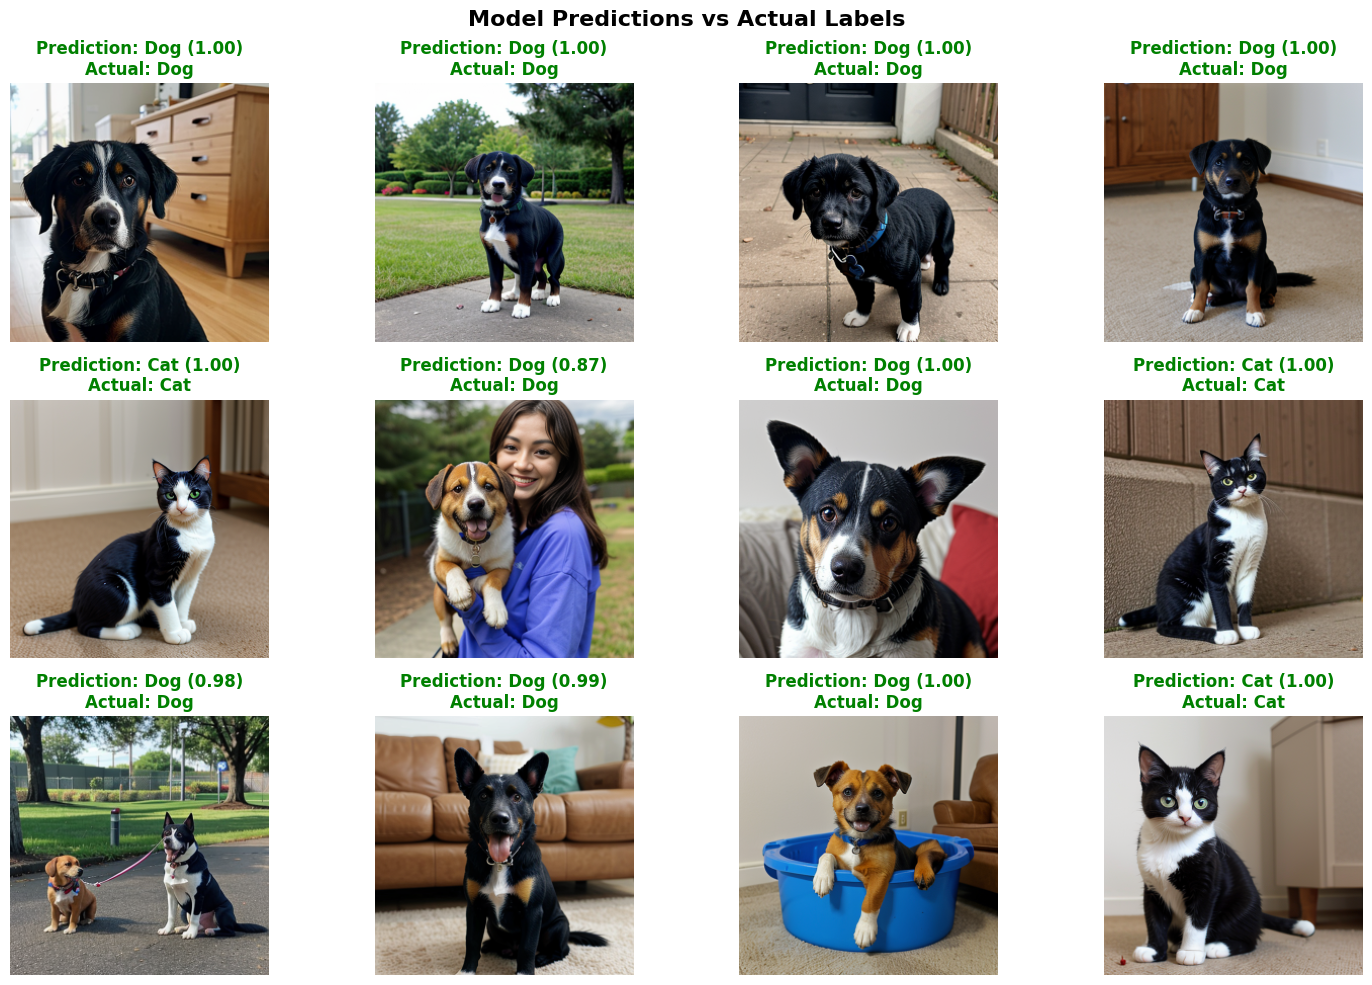

In [45]:
# Show prediction examples on validation images
plt.figure(figsize=(15, 10))

for images, labels in val_ds.take(1):
    predictions = model.predict(images)
    
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        
        # Determine predicted class and confidence
        predicted_class = 'Dog' if predictions[i] > 0.5 else 'Cat'
        actual_class = class_names[labels[i]]
        confidence = predictions[i][0] if predictions[i] > 0.5 else 1 - predictions[i][0]
        
        # Color code: green for correct, red for incorrect
        color = 'green' if predicted_class == actual_class else 'red'
        plt.title(f'Prediction: {predicted_class} ({confidence:.2f})\nActual: {actual_class}', 
                 color=color, fontweight='bold')
        plt.axis('off')
        
    break

plt.suptitle('Model Predictions vs Actual Labels', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 13. Results

In [ ]:
print("Cat vs Dog Classifier")

print("\nModel Architecture:")
print(f"   - Total parameters: {model.count_params():,}")
print(f"   - Input shape: {IMG_SIZE + (3,)}")
print("   - 4 Convolutional blocks + 2 Dense layers")
print("   - Dropout regularization to prevent overfitting")

print("\nDataset Information:")
print(f"   - Training samples: {len(list(train_ds)) * BATCH_SIZE}")
print(f"   - Validation samples: {len(list(val_ds)) * BATCH_SIZE}")
print("   - Image size: 256x256 pixels")
print("   - Classes: Cat (0), Dog (1)")

print("\nModel Saved:")
print("   - Filename: best_cat_dog_model.h5")
print("   - Contains the best model weights from training")
print("   - Can be loaded with: tf.keras.models.load_model('best_cat_dog_model.h5')")